In [2]:
from __future__ import print_function
import urllib
import bz2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import utils_IO as utils_IO
import utils_BA as utils_BA
import utils_plotting as utils_plotting
import matplotlib.image as mpimg

In [3]:
TOP_IMG_HEIGHT=168
BOT_IMG_HEIGHT=238
IMG_WIDTH= 396
P_X_BOT = P_X_TOP = IMG_WIDTH // 2
P_Y_BOT = BOT_IMG_HEIGHT // 2
P_Y_TOP = TOP_IMG_HEIGHT // 2
#(Camera, Coordinates)
#OFFSET = np.asarray([[P_Y_TOP, P_X_TOP], [P_Y_BOT, P_X_BOT]])
OFFSET = np.asarray([[P_X_TOP, P_Y_TOP], [P_X_BOT, P_Y_BOT]])

print(OFFSET)

[[198  84]
 [198 119]]


In [4]:
def ordered_arr_3d_to_dict(pts_array_3d, info_dict):
    '''assuming you used np.flatten(). to create the 3d points.
    and assuming that the pts array is full size, including nans.'''
    pose_dict = {}
    pose_dict["x_coords"] = pts_array_3d[:,0].reshape(
            info_dict["num_frames"], info_dict["num_analyzed_body_parts"])
    pose_dict["y_coords"] = pts_array_3d[:,1].reshape(
            info_dict["num_frames"], info_dict["num_analyzed_body_parts"])
    pose_dict["z_coords"] = pts_array_3d[:,2].reshape(
            info_dict["num_frames"], info_dict["num_analyzed_body_parts"])
    return pose_dict

In [5]:
def refill_nan_array(pts_array_clean, info_dict, dimension):
    '''we take our chopped array and embedd it in a full array with nans'''
    if dimension == '3d':
        pts_refill = np.empty((info_dict["num_frames"]*
                               info_dict["num_analyzed_body_parts"],3))
        pts_refill[:] = np.NaN
        pts_refill[info_dict["clean_point_indices"],:] = pts_array_clean
    else:
        pts_all_flat = np.arange(info_dict["num_frames"]*
                               info_dict["num_analyzed_body_parts"])
        indices_init = np.concatenate([pts_all_flat,pts_all_flat])

        pts_refill = np.empty((info_dict["num_frames"]*
                               info_dict["num_analyzed_body_parts"]*
                               info_dict["num_cameras"],2))
        pts_refill[:] = np.NaN
        pts_refill[np.isin(indices_init, 
                           info_dict["clean_point_indices"]),:] = pts_array_clean
    return pts_refill

In [6]:
def arr_2d_to_list_of_dicts(pts_array_2d, info_dict):
    '''this works assuming that you flattened the x,y coords from the dataframe.'''
    coord_list_of_dicts = []
    for cam in range(info_dict["num_cameras"]):
        
        row_indices = np.arange(cam*(pts_array_2d.shape[0]/info_dict["num_cameras"]),
          (cam+1)*(pts_array_2d.shape[0]/info_dict["num_cameras"])).astype(int)
        
        coord_dict = {}
        coord_dict["x_coords"] = pts_array_2d[row_indices,0].reshape(
                    info_dict["num_frames"],  info_dict["num_analyzed_body_parts"])
        coord_dict["y_coords"] = pts_array_2d[row_indices,1].reshape(
                     info_dict["num_frames"], info_dict["num_analyzed_body_parts"])
        
        coord_list_of_dicts.append(coord_dict)
    return coord_list_of_dicts

In [7]:
print(os.getcwd())
data_folder = 'mouseRunningData'

/Users/Sunsmeister/Desktop/Research/Brain/MultiView/test/3D-Animal-Pose


In [8]:
DLC_dframe = pd.read_csv(data_folder + '/CollectedData_.csv', 
                         header = [1,2]) 
# header = [1,2] is important. Provides a hierarchical data frame
DLC_dframe.head() # inspect
#DLC_dframe['paw1LH_top','x'] # that's how you index.

bodyparts paw1LH_top         paw2LF_top              \
                         coords          x       y          x           y   
0  barObstacleScaling1/img1.png      77.25   36.25     253.50  101.900393   
1  barObstacleScaling1/img2.png      37.25  110.75     285.75  104.750000   
2  barObstacleScaling1/img3.png     123.25  110.25     325.25  114.750000   
3  barObstacleScaling1/img4.png     125.25  106.75     230.25   51.250000   
4  barObstacleScaling1/img5.png      67.75   98.25     269.75  103.250000   

  paw3RF_top         paw4RH_top         tailBase_top  ... tailBase_bot  \
           x       y          x       y            x  ...            x   
0     198.75   97.75     182.25   63.75          NaN  ...        84.75   
1     253.25  101.75      46.75  129.75        49.25  ...        54.25   
2     279.25  103.25      39.75  143.75          NaN  ...        74.75   
3     317.75  113.25      70.25  123.25        55.75  ...        77.25   
4     305.75   96.25      29.25   72.75        65.25  ...        82.75   

          tailMid_bot         nose_bot         obsHigh_bot         obsLow_bot  \
        y           x       y        x       y           x       y          x   
0  329.75       46.25  332.75   381.25  281.75       74.25  184.25      74.75   
1  304.75       27.25  313.75   382.25  282.25      121.25  184.75     118.75   
2  318.25       34.75  389.75   383.25  280.75      236.25  198.25     234.75   
3  309.75       32.75  317.75   383.25  280.25      222.25  198.75     213.75   
4  323.25       35.75  339.25   381.75  280.25      116.25  192.25     112.25   

           
        y  
0  386.25  
1  385.75  
2  381.75  
3  380.25  
4  381.25  

[5 rows x 35 columns]

In [9]:
# change the bodyparts, coords entries.
DLC_dframe = DLC_dframe.rename(columns = { \
    "bodyparts":"img_name", "coords":"img_name" })
DLC_dframe.head()

img_name paw1LH_top         paw2LF_top              \
                       img_name          x       y          x           y   
0  barObstacleScaling1/img1.png      77.25   36.25     253.50  101.900393   
1  barObstacleScaling1/img2.png      37.25  110.75     285.75  104.750000   
2  barObstacleScaling1/img3.png     123.25  110.25     325.25  114.750000   
3  barObstacleScaling1/img4.png     125.25  106.75     230.25   51.250000   
4  barObstacleScaling1/img5.png      67.75   98.25     269.75  103.250000   

  paw3RF_top         paw4RH_top         tailBase_top  ... tailBase_bot  \
           x       y          x       y            x  ...            x   
0     198.75   97.75     182.25   63.75          NaN  ...        84.75   
1     253.25  101.75      46.75  129.75        49.25  ...        54.25   
2     279.25  103.25      39.75  143.75          NaN  ...        74.75   
3     317.75  113.25      70.25  123.25        55.75  ...        77.25   
4     305.75   96.25      29.25   72.75        65.25  ...        82.75   

          tailMid_bot         nose_bot         obsHigh_bot         obsLow_bot  \
        y           x       y        x       y           x       y          x   
0  329.75       46.25  332.75   381.25  281.75       74.25  184.25      74.75   
1  304.75       27.25  313.75   382.25  282.25      121.25  184.75     118.75   
2  318.25       34.75  389.75   383.25  280.75      236.25  198.25     234.75   
3  309.75       32.75  317.75   383.25  280.25      222.25  198.75     213.75   
4  323.25       35.75  339.25   381.75  280.25      116.25  192.25     112.25   

           
        y  
0  386.25  
1  385.75  
2  381.75  
3  380.25  
4  381.25  

[5 rows x 35 columns]

In [10]:
bodyparts = list(DLC_dframe.columns.levels[0][1:]) # [1:] to remove img name
print(bodyparts)

['nose_bot', 'nose_top', 'obsHigh_bot', 'obsLow_bot', 'obs_top', 'paw1LH_bot', 'paw1LH_top', 'paw2LF_bot', 'paw2LF_top', 'paw3RF_bot', 'paw3RF_top', 'paw4RH_bot', 'paw4RH_top', 'tailBase_bot', 'tailBase_top', 'tailMid_bot', 'tailMid_top']


In [11]:
def read_image(image_path, flip):
    '''if necessary, we can flip to make it easier to plot on top of the image.'''
    im = mpimg.imread(image_path)
    if flip:
        im = np.flipud(im)
    return im

In [12]:
def make_image_array(img_indexes, flip):
    im_shape = read_image(img_indexes[0], flip).shape # read first img
    num_frames = len(img_indexes)
    img_array = np.zeros((im_shape[0], im_shape[1], num_frames))
    print(img_array.shape)
    for i in range(num_frames):
        img_array[:,:,i] = read_image(img_indexes[i], flip) # function defined above

    return img_array

In [13]:
path_images = data_folder + \
                '/' + \
                DLC_dframe["img_name", "img_name"]\
                .to_numpy()
print(path_images.shape)

(1045,)


In [14]:
im_arr = make_image_array(path_images[0:10], flip = False)



(406, 396, 10)


In [15]:
def plot_image_labels(image, coord_list_of_dicts, index, color_list, ax = None):
    '''ToDo: add multiple data sources, so instead of x_arr, y_arr have a list of dicts
    with x,y coords. '''
    nrows, ncols = image.shape
    assert(len(color_list)==len(coord_list_of_dicts))
    if ax == None:
        plt.axis('off')
        plt.imshow(image, 'gray')
        plt.scatter(x_arr, y_arr)
    else:
        ax.axis('off')
        ax.set_xlim(-10,ncols+10) # pad x,y axes
        ax.set_ylim(nrows+10, -10)

        ax.imshow(image, 'gray')
        for i in range(len(coord_list_of_dicts)):
            x_coord = np.copy(coord_list_of_dicts[i]["x_coords"][index,:])
            y_coord = np.copy(coord_list_of_dicts[i]["y_coords"][index,:])

            # indices 0 and 2 correspond to the bottom image.
            # Recall, we subtracted out the height of the top
            # image earlier.
            if i % 2 == 0:
                y_coord += TOP_IMG_HEIGHT
            ax.scatter(x_coord, 
                       y_coord,
                      color = color_list[i])

In [16]:
def plot_3d_points(coord_list_of_dicts,
                   lims_dict,
                   index,
                   color_list,
                   ax):
    '''plot a single frame
    ToDo: specify plotting patams, allow for multiple inputs'''
    
    assert(len(color_list)==len(coord_list_of_dicts))

    ax.set_xlim3d(lims_dict["x"])
    ax.set_ylim3d(lims_dict["y"])
    ax.set_zlim3d(lims_dict["z"])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    for i in range(len(coord_list_of_dicts)):
        ax.plot(coord_list_of_dicts[i]["x_coords"][index,:], \
                coord_list_of_dicts[i]["y_coords"][index,:], \
                coord_list_of_dicts[i]["z_coords"][index,:],
                linestyle = 'None', 
                marker = 'o', 
                color = color_list[i], markersize=4, label = None)

In [17]:
# # older, worked
# def plot_3d_points(x_coords, 
#                    y_coords, 
#                    z_coords, 
#                    lims_dict,
#                    color,
#                    ax):
#     '''plot a single frame
#     ToDo: specify plotting patams, allow for multiple inputs'''
    
#     ax.set_xlim3d(lims_dict["x"])
#     ax.set_ylim3d(lims_dict["y"])
#     ax.set_zlim3d(lims_dict["z"])
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
    
#     ax.plot(x_coords, \
#             y_coords, \
#             z_coords,
#             color=color, lw = 1, markersize=4, label = None)

In [18]:
# pick either all body parts or part of them
#bp2plot = ['nose_bot', 'nose_top', 'tailBase_bot', 'tailBase_top']
bp2plot = bodyparts
pose_2D_dict = {}
pose_2D_dict["x_coords"] = DLC_dframe.loc[: , (bp2plot , 'x')].to_numpy() # DLC_dframe[bp2plot]
pose_2D_dict["y_coords"] = DLC_dframe.loc[: , (bp2plot , 'y')].to_numpy() # DLC_dframe[bp2plot]

In [19]:
# using https://stackoverflow.com/questions/12897374/get-unique-values-from-a-list-in-python
'''just these body parts that are seen from both views.'''
bp2plot = bodyparts
bp_short = []
for i in range(len(bp2plot)):
    if bp2plot[i][:3] != 'obs': # not plotting the obstacle
        bp_short.append(bp2plot[i][:-4]) # last four chars (_top/_bot)

short_list = list(set(bp_short)) # set returns unique elements in list
short_list_bot = []
short_list_top = []
for i in short_list:
    short_list_bot.append(i + '_bot')
    short_list_top.append(i + '_top')

tuple_x= (short_list_top, 'x')
tuple_y= (short_list_top, 'y')
tuple_z = (short_list_bot, 'y') #Remember to negate (right-hand-rule)

Normalizing / Re-mapping coordinates for bottom image

In [20]:
# Treat bottom image separately
# Remap y-values for bottom image
DLC_dframe.loc[: , tuple_z] -= TOP_IMG_HEIGHT

In [21]:
# extract 3d from rick
pose_dict_3d = {}
pose_dict_3d["x_coords"] = DLC_dframe.loc[: , \
                            tuple_x].to_numpy() # DLC_dframe[bp2plot]
pose_dict_3d["y_coords"] = DLC_dframe.loc[: , \
                            tuple_y].to_numpy() #/ DLC_dframe[bp2plot]

pose_dict_3d["z_coords"] = - DLC_dframe.loc[: , \
                           tuple_z].to_numpy()  # DLC_dframe[bp2plot]



In [22]:
# transform to BA format
pts_array_3d = np.hstack([pose_dict_3d["x_coords"].flatten().reshape(-1,1), 
           pose_dict_3d["y_coords"].flatten().reshape(-1,1),
                         pose_dict_3d["z_coords"].flatten().reshape(-1,1)])

print('original number of unique pts was %d' % pts_array_3d.shape[0])
nan_pts_3d = np.isnan(pts_array_3d).any(axis=1) # remove 3d points here and in each view
print(nan_pts_3d.shape)

original number of unique pts was 7315
(7315,)


In [23]:
# removing_nans
print('excluding %d tracked points!' % np.sum(nan_pts_3d==True)) # number of excluded 3d points.
pts_array_3d_clean = pts_array_3d[~nan_pts_3d, :]
pts_all_flat = np.arange(pts_array_3d.shape[0])
clean_point_indices = pts_all_flat[~nan_pts_3d]

#(clean_point_indices == np.where(~nan_pts_3d)).all() # True
info_dict = {}
info_dict["num_frames"] = DLC_dframe.shape[0]
info_dict["num_analyzed_body_parts"] = len(short_list)
info_dict["num_cameras"] = 2
info_dict["num_points_all"] = pts_array_3d.shape[0]
info_dict["clean_point_indices"] = pts_all_flat[~nan_pts_3d]
assert(info_dict["num_points_all"] == 
           info_dict["num_frames"]*info_dict["num_analyzed_body_parts"])

excluding 618 tracked points!


In [24]:
# extract params for BA. assuming all points are visible from the two cameras (even if nans)
# only body parts that are visible in both views
tuple_x_bot = (short_list_bot, 'x')
tuple_y_bot = (short_list_bot, 'y')
tuple_x_top = (short_list_top, 'x')
tuple_y_top = (short_list_top, 'y')

# hstack x,y
pts_array_2d_bot_full = np.hstack([DLC_dframe.loc[: , \
        tuple_x_bot].to_numpy().flatten().reshape(-1,1),
                             DLC_dframe.loc[: , \
        tuple_y_bot].to_numpy().flatten().reshape(-1,1)])

# remove nan_pts_3d rows
pts_array_2d_bot = pts_array_2d_bot_full[~nan_pts_3d, :]

# hstack x,y, and remove nan_pts_3d rows.
pts_array_2d_top_full = np.hstack([DLC_dframe.loc[: , \
        tuple_x_top].to_numpy().flatten().reshape(-1,1),
                             DLC_dframe.loc[: , \
        tuple_y_top].to_numpy().flatten().reshape(-1,1)])

pts_array_2d_top = pts_array_2d_top_full[~nan_pts_3d, :]

print('shape of each 2d pt array is %s and %s' %(
    str(pts_array_2d_bot.shape),
    str(pts_array_2d_top.shape)))

shape of each 2d pt array is (6697, 2) and (6697, 2)


In [25]:
# # concat 2d pts, concat pt indices first bot, then top. 
pts_array_2d = np.vstack([pts_array_2d_bot, pts_array_2d_top]) # bot first, top second.
#point_indices = np.concatenate([pt_indices_bot, pt_indices_top])
camera_indices = np.concatenate([np.zeros(pts_array_2d_bot.shape[0]),
                           np.ones(pts_array_2d_top.shape[0])]).astype(int) # bot = cam0, top = cam1
point_indices = np.tile(np.arange(pts_array_2d_bot.shape[0])
                        ,2).astype(int)

In [26]:
# # test that you can go back and forth between chopped arr and full arr with nans
# array_3d_back = refill_nan_array(pts_array_3d_clean, 
#                               info_dict, 
#                               dimension = '3d')
# pose_dict_3d_refill = ordered_arr_3d_to_dict(array_3d_back, info_dict)
# plt.scatter(pose_dict_3d_refill["z_coords"][:,0], pose_dict_3d["z_coords"][:,0])

In [27]:
# array_2d_back = refill_nan_array(pts_array_2d, 
#                               info_dict, 
#                                dimension = '2d')
# pose_list_2d_refill = arr_2d_to_list_of_dicts(array_2d_back,
#                                               info_dict)

# to do
1. sort file names by their integer. make sure that 1,2 ... 10 and not 1,10,2...
2. make sure you can load images and plot them as video using open cv / ffmpeg.
3. when this is done, we move to the format of creating single figures, saving these as images, and writing a movie.
4. this is in order to abstract the code a little bit and have one module for each of the following:
5. scatter points on an image.
6. create figures per trace.
7. 4.3. 3D plotting of objects.

In [28]:
# # these are not the same data!
# plt.scatter(dict_test["y_coords"][:,0], 
#             pts_2d_dict_bot_full["y_coords"][:,0])
# # utils_IO.revert_ordered_arr_2d_to_dict doesn't work in this case.

In [29]:
ind_start = 155 # will grab barObstacleScaling1/img(ind_start-1).png
num_frames = 255
ind_end = ind_start + num_frames

In [30]:
# we are padding the limits of the axis since some points lie at the border.
pad = 10
lims = {}
lims["x"], lims["y"], lims["z"] = \
        [np.nanmin(pose_dict_3d["x_coords"])-pad, \
         np.nanmax(pose_dict_3d["x_coords"])+pad], \
        [np.nanmin(pose_dict_3d["y_coords"])-pad, \
         np.nanmax(pose_dict_3d["y_coords"])+pad], \
        [np.nanmin(pose_dict_3d["z_coords"])-pad, \
         np.nanmax(pose_dict_3d["z_coords"])+pad]

In [31]:
lims["x"]

[-5.7, 403.937790870667]

solve the problem of the nans here, before any optimization.
let's see if we can go back from our observation removal.

In [32]:
points_3d = np.copy(pts_array_3d_clean)
points_2d = np.copy(pts_array_2d)

In [33]:
# init camera_params
#camera_params = np.random.rand(2,7) # was 2 +
#camera_params[0,0:6] = 0
camera_params = np.zeros((2,7)) # was 2 +
#camera_params[:,-2:] = np.zeros((2,2)) # init with zero distort

In [34]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]
n_frames = DLC_dframe.shape[0]

n = 7 * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
#print("n_frames: {}".format(n_frames)) # recall three points per frame
print("n_points: {}".format(n_points))
print("Total number of parameters: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 2
n_points: 6697
Total number of parameters: 20105
Total number of residuals: 26788


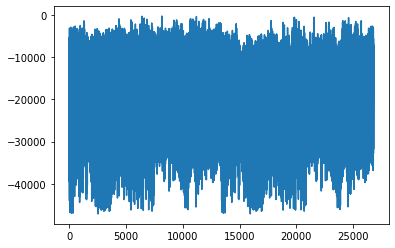

In [35]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
f0 = utils_BA.fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d, OFFSET)
plt.plot(f0)

In [36]:
A = utils_BA.bundle_adjustment_sparsity(
    n_cameras, n_points, camera_indices, point_indices)
print(A.shape)

(26788, 20105)


In [37]:
import time
from scipy.optimize import least_squares

In [38]:
t0 = time.time()
res = least_squares(utils_BA.fun, x0, jac_sparsity=A, 
                    verbose=2, x_scale='jac', 
                    ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, 
                          camera_indices, 
                          point_indices, points_2d, OFFSET))
t1 = time.time()

Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.7366e+12                                    8.18e+12    
       1              2         1.5043e+10      5.72e+12       5.15e+03       3.61e+11    
       2              3         2.8782e+08      1.48e+10       2.78e+03       4.13e+09    
       3              4         1.1208e+08      1.76e+08       6.25e+03       1.69e+10    
       4              5         7.1976e+06      1.05e+08       3.25e+03       2.32e+09    
       5              7         4.2054e+06      2.99e+06       5.69e+03       2.01e+09    
       6              8         8.5333e+05      3.35e+06       1.14e+04       2.67e+09    
       7              9         8.5699e+04      7.68e+05       1.49e+03       1.36e+08    
       8             10         7.5790e+04      9.91e+03       2.25e+02       5.00e+06    
       9             11         7.5779e+04      1.13e+01       1.87e+01       8.91e+05    
  

In [39]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 2 seconds


In [40]:
camera_params = res.x[:n_cameras * 7].reshape((n_cameras, 7))
points_3d = res.x[n_cameras * 7:].reshape((n_points, 3))
points_proj = utils_BA.project(points_3d[point_indices], camera_params[camera_indices], OFFSET[camera_indices])
print('points_proj: ', points_proj.shape)

points_proj:  (13394, 2)


In [46]:
import os
plot_folder = 'rick_plots'
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

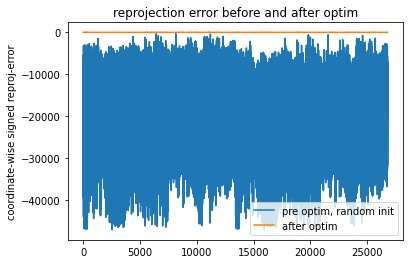

In [48]:
plt.plot(f0, label = 'pre optim, random init')
plt.plot(res.fun, label = 'after optim')
plt.legend()
plt.ylabel('coordinate-wise signed reproj-error')
#plt.xlabel('3 points X 1500 frames X 2 cameras X 2 coords')
plt.title('reprojection error before and after optim')
plt.savefig(os.path.join(plot_folder,'reproj-err-per-frame-initdlc3d.png'))

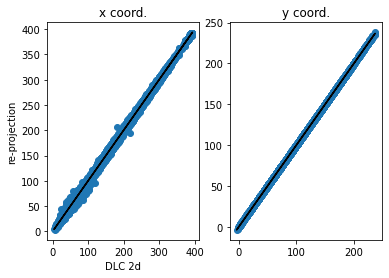

In [49]:
plt.subplot(121)
plt.scatter(points_2d[:,0], points_proj[:,0])
plt.plot(points_2d[:,0], points_2d[:,0], 'k')
plt.xlabel('DLC 2d')
plt.ylabel('re-projection')
plt.title('x coord.')
plt.subplot(122)
plt.title('y coord.')
plt.scatter(points_2d[:,1], points_proj[:,1])
plt.plot(points_2d[:,1], points_2d[:,1], 'k')
plt.savefig(os.path.join(plot_folder,'reprojection_scatter.png'))

In [50]:
#np.isin(indices_init, clean_point_indices)
print(short_list)

['nose', 'paw4RH', 'tailBase', 'tailMid', 'paw1LH', 'paw3RF', 'paw2LF']


In [51]:
# now we first refill the full sized containers, then revert to dicts.

# do the pts_array_3d_clean
array_3d_back = refill_nan_array(pts_array_3d_clean, 
                               info_dict, 
                               dimension = '3d')

pose_dict_3d_refill = ordered_arr_3d_to_dict(array_3d_back, info_dict)
# pts_3d_BA
BA_array_3d_back = refill_nan_array(points_3d, 
                               info_dict, 
                               dimension = '3d')
BA_dict = ordered_arr_3d_to_dict(BA_array_3d_back, info_dict)

# pts_2d_orig
print('pts_array_2d: ', pts_array_2d.shape)
array_2d_orig = refill_nan_array(pts_array_2d, 
                              info_dict, 
                               dimension = '2d')
print('array_2d_orig: ', array_2d_orig.shape)
pose_list_2d_orig = arr_2d_to_list_of_dicts(array_2d_orig,
                                              info_dict)
print('pose_list_2d_orig: ', pose_list_2d_orig[0]['x_coords'].shape)

# pts_2d_reproj
array_2d_reproj_back = refill_nan_array(points_proj, 
                              info_dict, 
                               dimension = '2d')
pose_list_2d_reproj = arr_2d_to_list_of_dicts(array_2d_reproj_back,
                                              info_dict)

pts_array_2d:  (13394, 2)
array_2d_orig:  (14630, 2)
pose_list_2d_orig:  (1045, 7)


In [52]:
ind_start = 155
ind_end = 160

In [53]:
joined_list_2d = pose_list_2d_orig + pose_list_2d_reproj
len(joined_list_2d)

4

In [54]:
joined_list_3d = []
joined_list_3d.append(pose_dict_3d_refill)
joined_list_3d.append(BA_dict)
len(joined_list_3d)

2

In [55]:
print(np.nanmin(np.array([joined_list_3d[0]["x_coords"].flatten(), 
          joined_list_3d[1]["x_coords"].flatten()])))
print(np.nanmax(np.array([joined_list_3d[0]["x_coords"].flatten(), 
          joined_list_3d[1]["x_coords"].flatten()])))

-336.2960329697489
620.9307099600444


In [58]:
#Red = ground truth, blue = proj
color_list_2d = ['red', 'red', 'blue', 'blue']
color_list_3d = ['red', 'blue']
# set limits to be the maximum of the two plots
# we are padding the limits of the axis since some points lie at the border.
pad = 10
lims = {}
lims["x"], lims["y"], lims["z"] = \
        [np.nanmin(np.array([joined_list_3d[0]["x_coords"].flatten(), 
          joined_list_3d[1]["x_coords"].flatten()]))-pad, \
         np.nanmax(np.array([joined_list_3d[0]["x_coords"].flatten(), 
          joined_list_3d[1]["x_coords"].flatten()])) +pad], \
        [np.nanmin(np.array([joined_list_3d[0]["y_coords"].flatten(), 
          joined_list_3d[1]["y_coords"].flatten()]))-pad, \
         np.nanmax(np.array([joined_list_3d[0]["y_coords"].flatten(), 
          joined_list_3d[1]["y_coords"].flatten()]))+pad], \
        [np.nanmin(np.array([joined_list_3d[0]["z_coords"].flatten(), 
          joined_list_3d[1]["z_coords"].flatten()]))-pad, \
         np.nanmax(np.array([joined_list_3d[0]["z_coords"].flatten(), 
          joined_list_3d[1]["z_coords"].flatten()]))+pad]

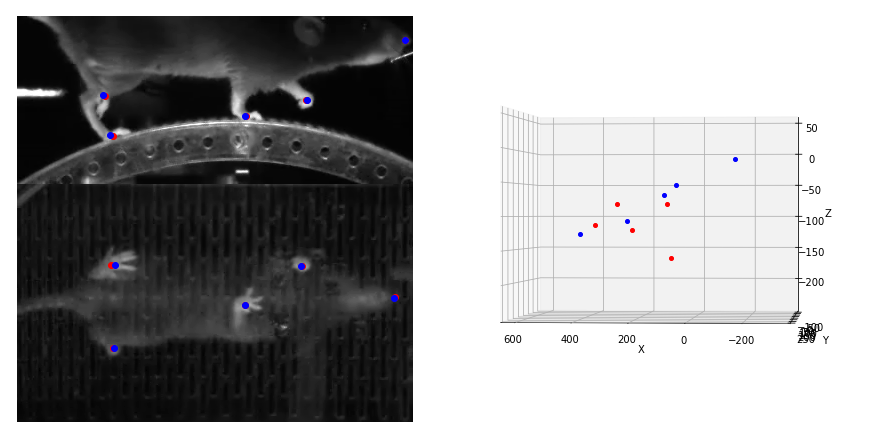

In [59]:
#### 3d plot
from matplotlib.gridspec import GridSpec
import mpl_toolkits.mplot3d.axes3d as p3
%matplotlib inline

fig = plt.figure(constrained_layout=True, figsize = (12,6))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1], projection = '3d') # https://matplotlib.org/3.1.1/gallery/mplot3d/subplot3d.html
image_folder = 'images_test'
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

ax2.view_init(elev=0, azim=90) # see https://stackoverflow.com/questions/12904912/how-to-set-camera-position-for-3d-plots-using-python-matplotlib

for i in range(ind_start,ind_end):
    # clear both ax1 and ax2
    ax1.cla()
    ax2.cla()   
    # load image
    img = read_image(path_images[i], flip=False)

    plot_image_labels(img,\
                        joined_list_2d,
                        i,
                        color_list_2d,
                        ax = ax1)
    
    ax2.azim += 1

    plot_3d_points(joined_list_3d,
                   lims,
                   i,
                   color_list_3d,
                   ax=ax2)
    im_int = str('%.5i' % i)
    plt.savefig(image_folder + '/' + 'im' + im_int + '.png')
    #plt.show()
    
    


In [60]:
# make video from these images
import cv2
import numpy as np
import os
im_list = os.listdir(image_folder)
im_list.sort()
im_list = im_list[1:]
 
img_array = []
for filename in im_list:
    img = cv2.imread(os.path.join(image_folder, filename))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('reconstruction.mp4',
                      cv2.VideoWriter_fourcc(*'DIVX'), 
                      5, size) # 15 fps
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()


In [61]:
pts_dict2d_dlc = utils_IO.revert_ordered_arr_2d_to_dict(len(short_list), 2, pts_array_2d)

In [62]:
pts_dict2d_dlc[0]["x_coords"].shape

(7, 956)

In [63]:
result_BA = {}
result_BA["camera_params"] = camera_params
result_BA["points_3d"] = points_3d
result_BA["points_proj"] = points_proj
utils_IO.save_object(result_BA, 'BA_result_Rick_04_11')

# Computing Fundamental Matrix

In [64]:
def skew(vector):
    """
    this function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)

    :param vector: An array like vector to create the skew symmetric cross product matrix for
    :return: A numpy array of the skew symmetric cross product vector
    """

    return np.array([[0, -vector[2], vector[1]], 
                     [vector[2], 0, -vector[0]], 
                     [-vector[1], vector[0], 0]])

In [65]:
from scipy.spatial.transform import Rotation as R
#Bundle adjustment code: https://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html

# Get rotation vector
rot_vec_1 = R.from_rotvec(camera_params[0, :3])
R1 = rot_vec_1.as_matrix()
print("R1: ", R1)
#Get translation vector
t1 = camera_params[0, 3:6]
print('t1: ', t1)
#Get focal length
f1 = camera_params[0, 6]
#Get offsets
p_x_1 = OFFSET[0, 0]
p_y_1 = OFFSET[0, 1]

print('f1: ', f1)
print('p_x_1: ', p_x_1)
print('p_y_1: ', p_y_1)

#Get intrinsic matrix
K1 = np.asarray([[f1, 0, p_x_1], [0, f1, p_y_1], [0, 0, 1]]) ###Add offset

print('-------------')
#Repeat for view 2
rot_vec_2 = R.from_rotvec(camera_params[1, :3])
R2 = rot_vec_2.as_matrix()
print("R2: ", R2)
t2 = camera_params[1, 3:6]
print('t2: ', t2)
f2 = camera_params[1, 6]
print('f2: ', f2)
#amera_params[1, 3:6]
f2 = camera_params[1, 6]
p_x_2 = OFFSET[1, 0]
p_y_2 = OFFSET[1, 1]
print('p_x_2: ', p_x_2)
print('p_y_2: ', p_y_2)

K2 = np.asarray([[f2, 0, p_x_2], [0, f2, p_y_2], [0, 0, 1]])

# --- Now compute relevant quantities for F estimation ------
#Camera matrix basics: http://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf
#Fundamental matrix computation: https://rb.gy/dd0nz2

#Compute projection matrices
P1 = np.matmul(K1, np.concatenate((R1, t1[:, np.newaxis]), axis=1))
P2 = np.matmul(K2, np.concatenate((R2, t2[:, np.newaxis]), axis=1))

#Get camera center (view 1)
R1_inv = np.linalg.inv(R1) 
C = np.matmul(-R1_inv, t1)
C = np.append(C, 1)

F = np.matmul(skew(np.matmul(P2, C)), np.matmul(P2, np.linalg.pinv(P1)))
print(F)

R1:  [[ 0.99395018 -0.08107879 -0.07408954]
 [ 0.05082428  0.93753903 -0.34414743]
 [ 0.09736489  0.33829985  0.93598787]]
t1:  [ 5.056917   -8.19601984 35.49800332]
f1:  3.0483509712427286
p_x_1:  198
p_y_1:  84
-------------
R2:  [[ 0.98959102 -0.13274208 -0.05558016]
 [ 0.10552649  0.93194766 -0.34689726]
 [ 0.09784566  0.33742124  0.93625485]]
t2:  [  4.38815822 -14.90847867  35.52970367]
f2:  3.1064675914238786
p_x_2:  198
p_y_2:  119
[[-5.01310527e-03 -1.57315699e-02 -1.95359845e+01]
 [ 2.27082262e-02 -2.21039577e-03 -9.19566839e-01]
 [ 2.03329675e+01 -1.29783479e+00  5.82082022e+00]]


In [66]:
def draw_circles(img, points):
    for point in points:
        cv2.circle(img,(point[0], point[1]), 10, (255,0,255), -1)
    return img

In [67]:
def slope(x1,y1,x2,y2):
    ###finding slope
    if x2!=x1:
        return((y2-y1)/(x2-x1))
    else:
        return 'NA'

def drawLine(image,x1,y1,x2,y2):

    m=slope(x1,y1,x2,y2)
    h,w=image.shape[:2]
    if m!='NA':
        ### here we are essentially extending the line to x=0 and x=width
        ### and calculating the y associated with it
        ##starting point
        px=0
        py=-(x1-0)*m+y1
        ##ending point
        qx=w
        qy=-(x2-w)*m+y2
    else:
    ### if slope is zero, draw a line with x=x1 and y=0 and y=height
        px,py=x1,0
        qx,qy=x1,h
    image = cv2.line(image, (int(px), int(py)), (int(qx), int(qy)), (255, 255, 255), 2)
    return image

In [70]:
epipolar_folder = './epipolar_lines/'
if not os.path.exists(epipolar_folder):
    os.makedirs(epipolar_folder)

for i in range(ind_start,ind_end):
    # load image
    img = read_image(path_images[i], flip=False)
    top_img = (img[0:TOP_IMG_HEIGHT, :] * 255).astype(np.uint8)
    bottom_img = (img[TOP_IMG_HEIGHT:, :] * 255).astype(np.uint8)
    
    #Recall, indices 0 and 2 correspond to bottom image
    x_t = joined_list_2d[1]['x_coords'][i][:,np.newaxis]
    y_t = joined_list_2d[1]['y_coords'][i][:,np.newaxis]

    x_b = joined_list_2d[0]['x_coords'][i][:,np.newaxis]
    y_b = joined_list_2d[0]['y_coords'][i][:,np.newaxis]

    points_top = np.concatenate((x_t,y_t), axis=1)
    points_bot = np.concatenate((x_b,y_b), axis=1)

    
    #Get rid of nans
    
    points_bot = points_bot.astype(np.int32)
    points_bot = points_bot[~np.isnan(points_bot).any(axis=1)]

    points_top = points_top.astype(np.int32)
    points_top = points_top[~np.isnan(points_top).any(axis=1)]


    top_img_with_points = draw_circles(top_img, points_top)
    bot_img_with_points = draw_circles(bottom_img, points_bot)
    #cv2.imwrite('epipolar_lines/top_image_points.jpg', top_img_with_points)
    #cv2.imwrite('epipolar_lines/bot_image_points.jpg', bot_img_with_points)

    #Homogenize points
    ones = np.ones(points_top.shape[0])[:,np.newaxis]
    points_top_homog = np.concatenate((points_top, ones), axis=-1)
    points_bot_homog = np.concatenate((points_bot, ones), axis=-1)
    
    aug_F = np.tile(F, (points_top_homog.shape[0], 1, 1))
    lines_bot = np.squeeze(np.matmul(aug_F, points_top_homog[:,:,np.newaxis]))
    #This^ gives us lines as vectors [a,b,c] --> ax + by + c = 0

    for line_vec in lines_bot:
        #Get x and y intercepts (on image) to plot

        #y = 0: x = -c/a
        x_intercept = int(-line_vec[2] / line_vec[0])
        #x = 0: y = -c/b
        y_intercept = int(-line_vec[2] / line_vec[1])
        bottom_img = drawLine(bottom_img, x_intercept, 0, 0, y_intercept)
        #bottom_img = cv2.line(bottom_img, (x_intercept, 0), (0, y_intercept), (255, 255, 255), thickness=1)



    cv2.imwrite(f'epipolar_lines/bot_{i}.jpg', bottom_img)


In [69]:
im_list = os.listdir(epipolar_folder)
im_list.sort()
im_list = im_list[1:]
 
img_array = []
for filename in im_list:
    img = cv2.imread(os.path.join(epipolar_folder, filename))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
    
out = cv2.VideoWriter('epipolar_video.mp4',
                      cv2.VideoWriter_fourcc(*'DIVX'), 
                      5, size) # 15 fps
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()


FileNotFoundError: [Errno 2] No such file or directory: './epipolar_lines/'

# Plot camera coordinate systems

In [129]:
import numpy as np 
import plotly.graph_objs as go

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):
    """Plot vectors using plotly"""

    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects

    data = []
    names = ['x', 'y', 'z']
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = names[i])
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    return data
    #fig = go.Figure(data=data,layout=layout)
    #fig.show()

In [130]:

data_1 = vector_plot([R1[:,0],R1[:,1],R1[:,2]], orig=t1)
data_2 = vector_plot([R2[:,0],R2[:,1],R2[:,2]], orig=t2)
layout = go.Layout(
            margin = dict(l = 4,
                        r = 4,
                        b = 4,
                        t = 4)
                )
data = data_1 + data_2

fig = go.Figure(data=data,layout=layout)
fig.show()